# Analyzing Individual Currencies

Here is where I will analyze a single currency.

In [4]:
# Import libraries/packages
import pandas as pd
import numpy as np
import requests
from datetime import datetime
!pip install stockstats -q
from stockstats import StockDataFrame
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_context("notebook")
sns.set_style("darkgrid")

## Functions To Help With The Data

In [2]:
# Function to download from cryptocompare
def download_data(from_symbol, to_symbol, exchange, datetime_interval, data_points):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals
    print('Downloading %s trading data for %s %s from %s.' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)
    params = {'fsym': from_symbol, 'tsym': to_symbol, 'limit': data_points, 'aggregate': 1, 'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data

# Function to convert downloaed json to dataframe
def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open', 'close', 'volumefrom', 'volumeto']]
    return df

# Load data from flat file
def read_dataset(filename):
    print('Reading data from %s.' %filename)
    df = pd.read_csv(filename)
    # Change type from object to datetime
    df.datetime = pd.to_datetime(df.datetime) 
    df = df.set_index('datetime') 
    df = df.sort_index()  # sort by datetime
    print(df.shape)
    return df

# Function to filter out empty records
def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print("Filtering %d empty datapoints." %indices.shape[0])
    df = df.drop(indices)
    return df

# Function for naming file to save flat file of downloaded data
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)

# Function to make candlesticks
def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms

I would like to modify this to where the downloaded data appends to the flat file only the newer data that is not already contained. I see this as an online system that gets updated data in real time and populates an interface as the data arrives.

## Downloading Data...

In [79]:
# Set paramters
from_symbol = 'BTC'           # as of 2021-09-28 ['BTC', 'ETH','XLM', 'COMP', 'GRT', 'USDT']
to_symbol = 'USD'             # likely to remain USD for a bit, I mean, unless...
exchange = 'Bitstamp'
datetime_interval = 'minute'  # datetime_interval should be one of {'hour', 'minute', 'day'}
data_points = 2000            # number of data points (max is 2000)

As of September 28, 2021, only the following currencies are compatible with this:

* BTC
* ETH
* XLM
* COMP
* GRT
* USDT

As there are numerous others that I am interested - some *a lot* more than a few in that lost - I will need to explore anothr means of getting data for those. I may need to explore Yahoo! for those.

In [80]:
# Download and load data to dataframe - save to flat file as needed
data = download_data(from_symbol, to_symbol, exchange, datetime_interval, data_points)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

Filtering 0 empty datapoints.


In [81]:
# Write data to flat file -- UNCOMMENT AS NEEDED!
#current_datetime = datetime.now().date().isoformat()
#filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
#print('Saving data to %s' % filename)
#df.to_csv(filename, index=False)

In [82]:
# Inspect dataframe
print(df.shape, "\n")
print(df.info(), "\n")
display(df.head())
display(df.tail())
display(df.describe())

(2001, 7) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    2001 non-null   datetime64[ns]
 1   low         2001 non-null   float64       
 2   high        2001 non-null   float64       
 3   open        2001 non-null   float64       
 4   close       2001 non-null   float64       
 5   volumefrom  2001 non-null   float64       
 6   volumeto    2001 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 125.1 KB
None 



,datetime,low,high,open,close,volumefrom,volumeto
0,2021-09-27 15:12:00,43075.00,43132.16,43097.85,43116.43,0.4054,17478.49
1,2021-09-27 15:13:00,43077.84,43116.43,43116.43,43078.42,0.2328,10030.52
2,2021-09-27 15:14:00,43062.21,43124.10,43078.42,43107.04,3.9740,171256.63
3,2021-09-27 15:15:00,43073.00,43137.38,43107.04,43137.38,1.3900,59909.16
4,2021-09-27 15:16:00,43096.69,43145.98,43137.38,43143.85,1.5210,65560.82


,datetime,low,high,open,close,volumefrom,volumeto
1996,2021-09-29 00:28:00,41087.22,41368.50,41087.22,41291.63,49.5000,2039409.80
1997,2021-09-29 00:29:00,41283.02,41454.00,41291.63,41430.84,3.5560,147152.13
1998,2021-09-29 00:30:00,41303.98,41430.84,41430.84,41303.98,0.0585,2416.51
1999,2021-09-29 00:31:00,41279.00,41482.63,41303.98,41418.72,2.7310,113035.14
2000,2021-09-29 00:32:00,41418.72,41484.52,41418.72,41484.52,0.0000,0.00


,low,high,open,close,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,42188.455952,42237.276287,42213.849125,42213.042864,1.742063,7.331867e+04
std,624.280185,619.143712,622.269553,622.168770,4.878545,2.042715e+05
min,40750.000000,40866.920000,40750.000000,40750.000000,0.000000,0.000000e+00
25%,41695.820000,41748.530000,41720.880000,41720.820000,0.113000,4.797300e+03
50%,42065.750000,42125.070000,42090.000000,42085.060000,0.502300,2.108929e+04
75%,42714.010000,42760.250000,42741.440000,42740.500000,1.642000,6.981106e+04
max,43334.080000,43425.800000,43415.110000,43415.110000,86.470000,3.686152e+06


## If Reading In From Previously Saved Flat File...

Uncomment this section's material and go to town, homey.

In [83]:
'''

# Load tools
import pandas as pd
import numpy as np
!pip install stockstats -q
from stockstats import StockDataFrame

# Load data from flat file
df = read_dataset(filename)

'''

'\n\n# Load tools\nimport pandas as pd\nimport numpy as np\n!pip install stockstats -q\nfrom stockstats import StockDataFrame\n\n# Load data from flat file\ndf = read_dataset(filename)\n\n'

## Start Looking

I will also consider Moving Average Convergence Divergence (MACD) here.

More MACD information can be found [here](https://www.investopedia.com/terms/m/macd.asp). This can be something to consider, based on [this information](https://www.investopedia.com/articles/forex/08/macd-combo.asp).Effectively, when the two moving avereges cross it *could* be a sign that a trend is accelerating and signal an entry.

Explore plotly for [candlestick plot](https://plotly.com/python/candlestick-charts/).

**UPDATE**

Check [this nonsense](https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682) right here. Yeah. This. Definitely boogle this. It could help find the special goodness.

In [90]:
# Make dataframe a time series
df = df.set_index("datetime") 
df = df.sort_index()

# Convert dataframe to StockDataFrame
df = StockDataFrame.retype(df)

# Get MACD column
df['macd'] = df.get('macd') # calculate MACD

In [91]:
df.tail()

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh
datetime,,,,,,,,,
2021-09-29 00:28:00,41087.22,41368.50,41087.22,41291.63,49.5000,2039409.80,15.401225,-26.450002,41.851227
2021-09-29 00:29:00,41283.02,41454.00,41291.63,41430.84,3.5560,147152.13,45.467452,-12.066511,57.533963
2021-09-29 00:30:00,41303.98,41430.84,41430.84,41303.98,0.0585,2416.51,58.385578,2.023907,56.361672
2021-09-29 00:31:00,41279.00,41482.63,41303.98,41418.72,2.7310,113035.14,76.994304,17.017986,59.976318
2021-09-29 00:32:00,41418.72,41484.52,41418.72,41484.52,0.0000,0.00,95.945364,32.803462,63.141902


In [93]:
## TEST PLOTTING CANDLESICKS WITH BOKEH (...meh...)

# Import tools for plotting
from math import pi
from bokeh.plotting import figure, show, output_notebook, output_file

# Output in notebook
output_notebook()

# Timeframe endpoints
datetime_from = '2016-01-01 00:00'
datetime_to = '2017-12-10 00:00'

df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close
title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)
p.line(df_limit.index, df_limit.close, color='black')

# Plot MACD strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# Plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

# Send plot to file
output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")

# Show plot in notebook
show(p)

Loading BokehJS ...

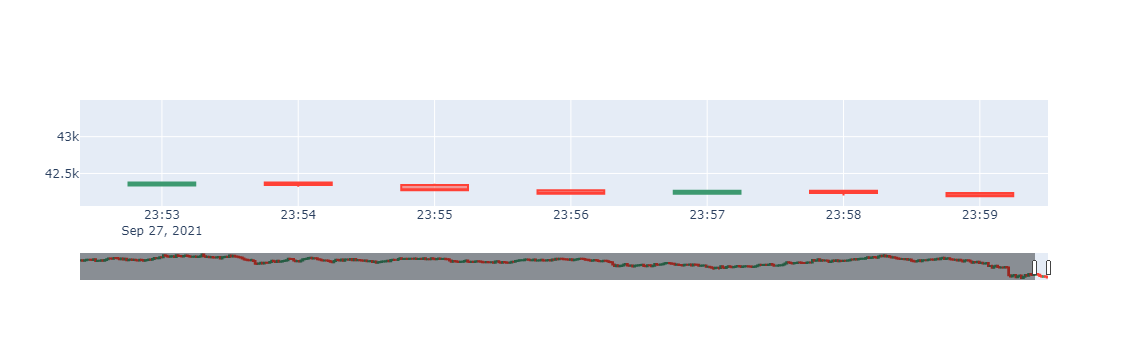

In [99]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime



fig = go.Figure(data=[go.Candlestick(x=df.loc['2021-09-27'].index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

### Focus on Bitcoin for a bit...

At first I want to explore daily data to get a sense of high level trend and possible seasonality in the prices. After that I will explore hourly data to see if there is any diurnal seasonality, or perhaps even a common "low" point during the day that may be a good time to apply DCA purchases.

I am not intentionaly ignoring minute frequency, rather; I am not familiar enough yet to know what to even do with such data, and my current thoughts are that such data may help me better prepare for "day trading," or other such moments when I wish to "manage a position" to optimize my gains when selling for profit.

In [5]:
# Set paramters
from_symbol = 'BTC'           # as of 2021-09-28 ['BTC', 'ETH','XLM', 'COMP', 'GRT', 'USDT']
to_symbol = 'USD'             # likely to remain USD for a bit, I mean, unless...
exchange = 'Bitstamp'
datetime_interval = 'day'  # datetime_interval should be one of {'hour', 'minute', 'day'}
data_points = 2000            # number of data points (max is 2000)

In [28]:
# Download and load data to dataframe
data = download_data(from_symbol, to_symbol, exchange, datetime_interval, data_points)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

# Make dataframe a time series
df = df.set_index("datetime", drop=False) 
df = df.sort_index()

# Add year, month, and days to dataframe
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.day_name()

Filtering 0 empty datapoints.


In [29]:
# Inspect
print(df.shape)
display(df.index)
display(df.head(3))
display(df.tail(3))

(2001, 10)


DatetimeIndex(['2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18',
               ...
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30'],
              dtype='datetime64[ns]', name='datetime', length=2001, freq=None)

,datetime,low,high,open,close,volumefrom,volumeto,Year,Month,Weekday Name
datetime,,,,,,,,,,
2016-04-09,2016-04-09,412.0,418.71,417.75,418.37,3578.63,1488490.68,2016,4,Saturday
2016-04-10,2016-04-10,417.2,421.79,418.59,420.77,1735.02,728035.88,2016,4,Sunday
2016-04-11,2016-04-11,418.0,422.80,420.40,422.08,3461.33,1455970.96,2016,4,Monday


,datetime,low,high,open,close,volumefrom,volumeto,Year,Month,Weekday Name
datetime,,,,,,,,,,
2021-09-28,2021-09-28,40888.00,42778.93,42189.81,41049.00,2246.85,93999112.34,2021,9,Tuesday
2021-09-29,2021-09-29,40750.00,42595.93,41049.00,41542.90,1804.78,75320676.22,2021,9,Wednesday
2021-09-30,2021-09-30,41427.87,43482.40,41542.90,43322.82,279.45,11895624.78,2021,9,Thursday


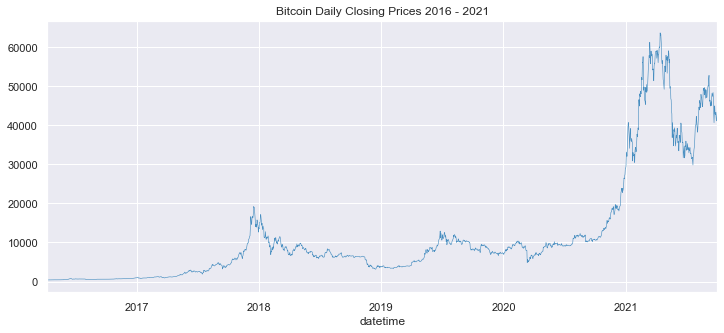

In [43]:
# Line plot of full time series
df['close'].plot(linewidth=0.6, alpha=0.8, figsize=(12,5), title='Bitcoin Daily Closing Prices 2016 - 2021');

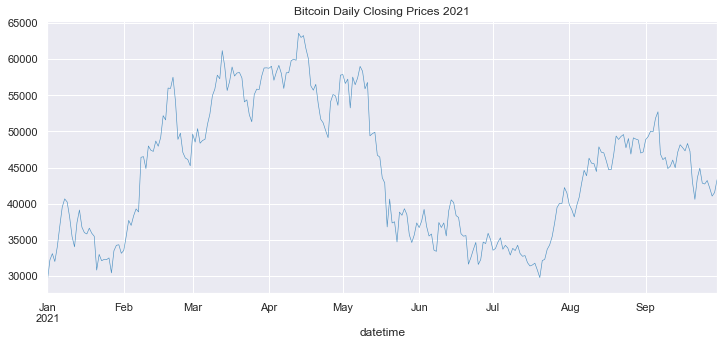

In [44]:
# Lineplot focus in on 2021
df['close'].loc['2021'].plot(linewidth=0.6, alpha=0.8, figsize=(12,5), title='Bitcoin Daily Closing Prices 2021');

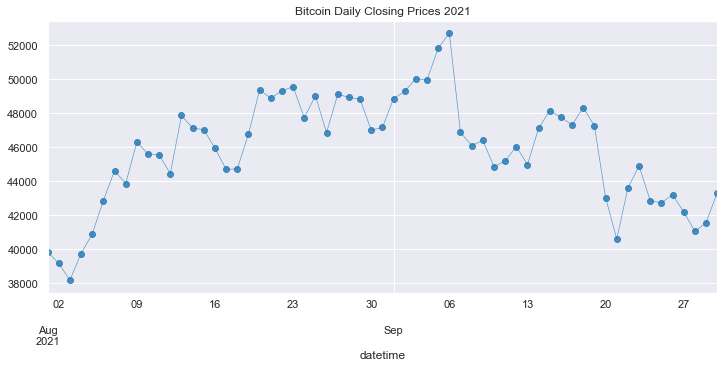

In [46]:
# Lineplot focus in on August - September 2021
df['close'].loc['2021-08':'2021-09'].plot(linewidth=0.6, alpha=0.8,
                                marker='o', linestyle='-',
                                figsize=(12,5), title='Bitcoin Daily Closing Prices 2021');

### Seasonality?

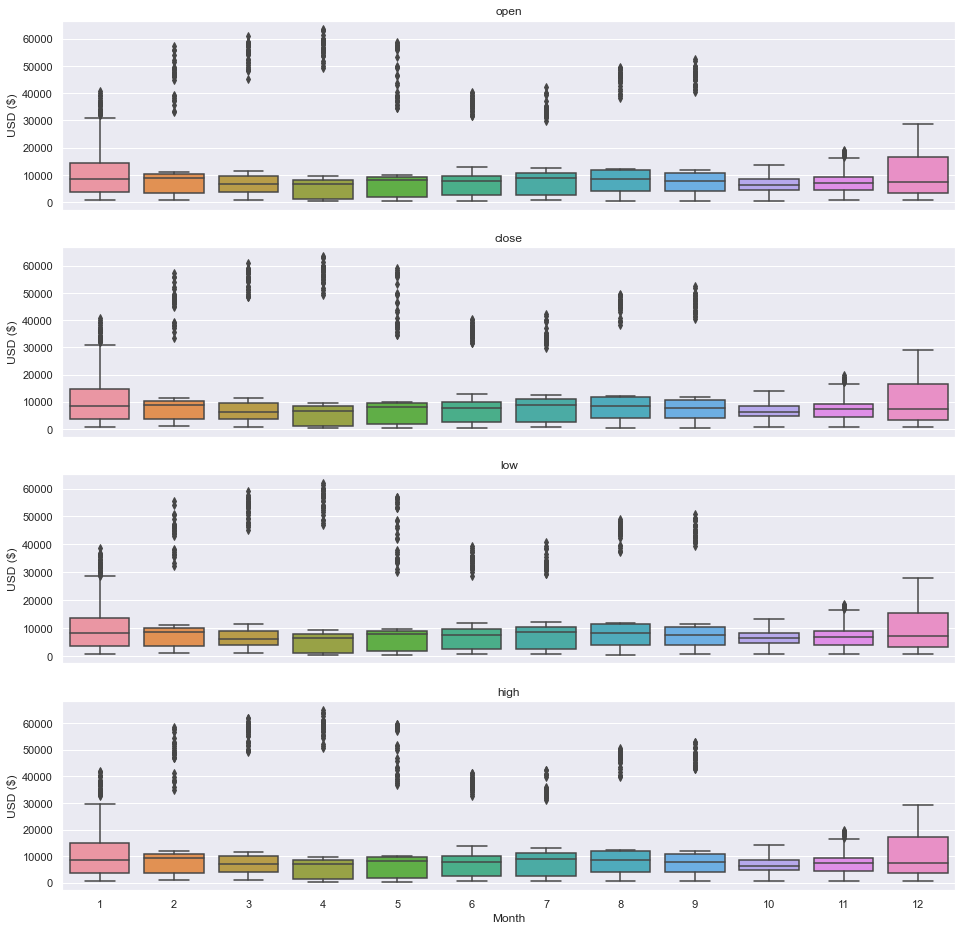

In [51]:
# Group by month, inspect yearly seasonality
fig, axes = plt.subplots(4, 1, figsize=(16,16), sharex=True)
for name, ax in zip(['open', 'close', 'low', 'high'], axes):
    sns.boxplot(data=df, x='Month', y=name, ax=ax)
    ax.set_ylabel('USD ($)')
    ax.set_title(name)
    
    # Remove automatic x-axis label from all but bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

The opening and closing prices look lower in April andMay historically. October and November also look low as well. Interesting that there are a number of outliers (outside the whiskers) in all months except October and December (few in November). Are early Q2 and Q4 the times to buy and December and January times to sell?

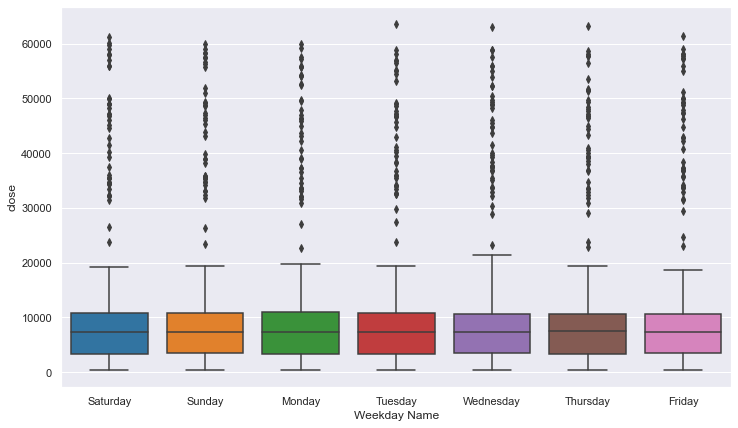

In [56]:
# Drill down into weekly grouping
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(data=df, x='Weekday Name', y='close', ax=ax);

Fairly uniform. About what I expected here.

In [57]:
### Hourly